In [1]:
import festim as F
import fenics as f
import numpy as np
import h_transport_materials as htm
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from MSPBPermFuncs import *

Model parameters:

In [2]:
t_substrate = 562e-06
t_barrier = 1e-06

T_array = np.arange(275, 401, 25) + 273

Assigning materials:

In [3]:
# barrier_D = htm.diffusivities.filter(material="tungsten")[1]
# barrier_S = htm.solubilities.filter(material="tungsten")[1]

# barrier_D = htm.diffusivities.filter(material="316l_steel").filter(author="reiter").filter(year=1996)[0]
# barrier_S = htm.solubilities.filter(material="316l_steel").filter(author="reiter").filter(year=1996)[0]
# substrate_D = htm.diffusivities.filter(material="316l_steel").filter(author="reiter").filter(year=1996)[0]
# substrate_S = htm.solubilities.filter(material="316l_steel").filter(author="reiter").filter(year=1996)[0]

barrier_D = htm.diffusivities.filter(material="eurofer_97")[0]
barrier_S = htm.solubilities.filter(material="eurofer_97")[0]
substrate_D = htm.diffusivities.filter(material="eurofer_97")[0]
substrate_S = htm.solubilities.filter(material="eurofer_97")[0]

In [4]:

computed_flux_array = []
for T in T_array:
    perm_model = F.Simulation()
    assign_materials(perm_model, barrier_D, barrier_S, substrate_D, substrate_S)
    mesh_model(perm_model, t_barrier, t_substrate)
    P_up = 1e04 # Pa
    apply_BCs(perm_model, float(T), P_up, barrier_S)
    folder = 'results'
    final_time = 1e03

    perm_model.log_level = 20

    perm_model.settings = F.Settings(
        absolute_tolerance=1e9,
        relative_tolerance=1e-8,
        final_time=final_time  # s
        )

    perm_model.dt = F.Stepsize(initial_value=0.1,
                            stepsize_change_ratio = 1.1)

    derived_quantities = run_model(perm_model, folder)

    computed_flux = derived_quantities.filter(surfaces=2, fields="solute").data
    computed_flux_array.append(-np.array(computed_flux)) # list of np arrays

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
0.0 %        1.0e-01 s    Elapsed time so far: 0.0 s
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.648e-05 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = 0.000e+00 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4

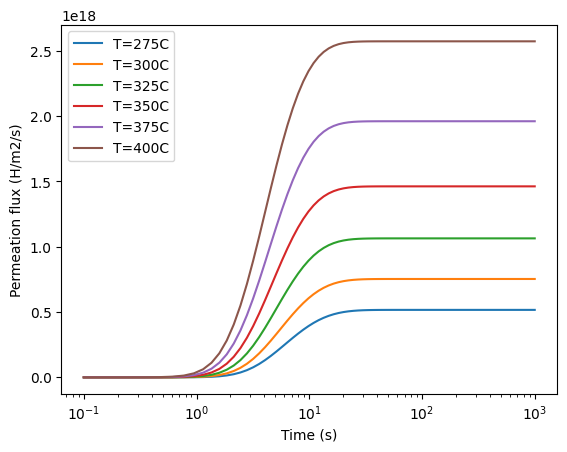

In [5]:
times = derived_quantities.t

plt.figure()
plt.xscale("log")
for i, T in enumerate(T_array):
    plt.plot(times, computed_flux_array[i], label=f"T={T-273}C")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Permeation flux (H/m2/s)")
plt.show()

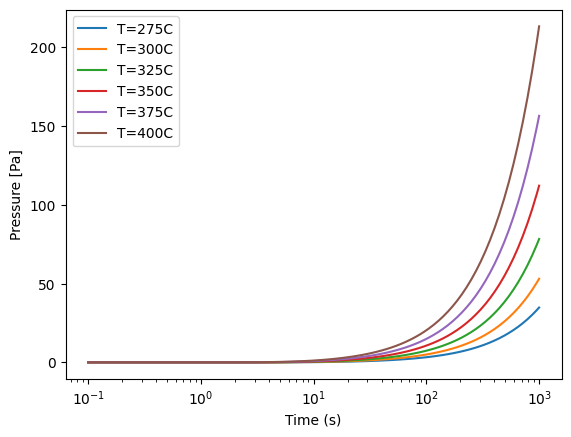

In [6]:
d = 20e-3  # mm to m
V = 35e-6  # 35 cm^3 to m^3
R = 8.314  # J/mol/K

plt.figure()
plt.xscale("log")
P_array = []
for i, T in enumerate(T_array):
    computed_flux = computed_flux_array[i]
    P = pressure_from_flux(computed_flux, times, d, V, T)
    P_array.append(P)
    plt.plot(times, P, label=f"T={T-273}C")

plt.xscale("log")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Pressure [Pa]")
plt.show()

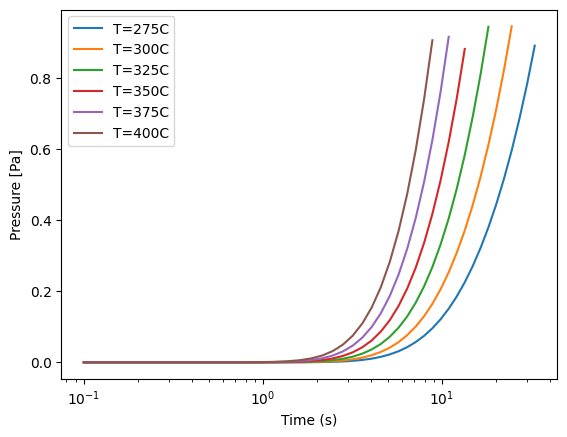

In [7]:
plt.figure()
plt.xscale("log")
times = np.array(times)
for i, T in enumerate(T_array):
    P = P_array[i]
    mask = P < 1
    filtered_times = times[mask]
    filtered_P = P[mask]
    plt.plot(filtered_times, filtered_P, label=f"T={T-273}C")

plt.xscale("log")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Pressure [Pa]")
plt.show()